# Inferring Dust Extinction Parameters from Simulated Galaxy Images

This notebook explores whether convolutional neural networks (CNNs) can learn
physically meaningful dust extinction parameters from noisy, simulated galaxy images.

The simulations are inspired by my PhD work on circumgalactic dust extinction and use GalSim to generate realistic imaging data including PSF convolution and noise.


In [37]:
import numpy as np
import matplotlib.pyplot as plt

import galsim
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
from sklearn.metrics import r2_score

In [4]:
torch.manual_seed(42)
np.random.seed(42)

## Physical model: dust extinction

We model dust extinction as a simple multiplicative attenuation of the intrinsic
galaxy surface brightness:

I_obs = I_intrinsic · exp(-τ)

where τ is an effective optical depth.

In [23]:
def simulate_galaxy(tau, image_size=64, pixel_scale=0.2):
    """
    Simulate a single galaxy image with dust extinction, PSF convolution, and noise.
    """
    # Intrinsic galaxy
    gal = galsim.Sersic(
        n=1.5,
        half_light_radius=0.7,
        flux=1e2)

    # Apply dust extinction
    gal = gal.withFlux(gal.flux * np.exp(-tau))

    # PSF
    psf = galsim.Gaussian(fwhm=0.7)

    # Convolve galaxy with PSF
    final = galsim.Convolve([gal, psf])

    # Draw image
    image = final.drawImage(
        nx=image_size,
        ny=image_size,
        scale=pixel_scale
    )

    # Add noise
    image.addNoise(galsim.GaussianNoise(sigma=0.02))

    return image.array

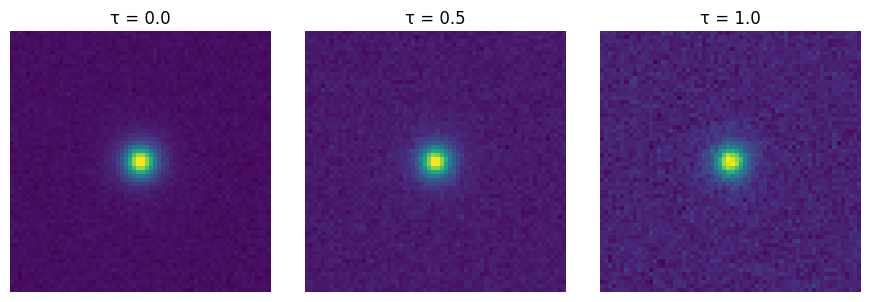

In [24]:
# Check the simulated data

taus = [0.0, 0.5, 1.0]
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

for ax, tau in zip(axes, taus):
    img = simulate_galaxy(tau)
    ax.imshow(img, origin="lower", cmap="viridis")
    ax.set_title(f"τ = {tau}")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [25]:
def generate_dataset(n_samples=5000):
    images = []
    labels = []

    for _ in tqdm(range(n_samples)):
        tau = np.random.uniform(0.0, 1.5)
        img = simulate_galaxy(tau)
        images.append(img)
        labels.append(tau)

    return np.array(images), np.array(labels)

In [26]:
#Torch dataset wrapper

class GalaxyDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.tensor(images, dtype=torch.float32).unsqueeze(1)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [27]:
# Train/validation split

images, labels = generate_dataset()

split = int(0.8 * len(labels))
train_ds = GalaxyDataset(images[:split], labels[:split])
val_ds   = GalaxyDataset(images[split:], labels[split:])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64)

100%|██████████| 5000/5000 [00:05<00:00, 998.42it/s] 


In [28]:
# CNN Model definition

class DustCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),

            nn.Flatten(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze()

In [29]:
# Training setup

device = "cuda" if torch.cuda.is_available() else "cpu"

model = DustCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [16]:
# Training loop
def train_epoch(loader):
    model.train()
    loss_sum = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()

    return loss_sum / len(loader)

In [18]:
# Validation loop

def eval_epoch(loader):
    model.eval()
    loss_sum = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            loss_sum += loss.item()

    return loss_sum / len(loader)

In [30]:
# Run training

for epoch in range(10):
    train_loss = train_epoch(train_loader)
    val_loss = eval_epoch(val_loader)

    print(f"Epoch {epoch:02d} | Train: {train_loss:.4f} | Val: {val_loss:.4f}")

Epoch 00 | Train: 0.2685 | Val: 0.1764
Epoch 01 | Train: 0.1470 | Val: 0.0332
Epoch 02 | Train: 0.0095 | Val: 0.0063
Epoch 03 | Train: 0.0063 | Val: 0.0064
Epoch 04 | Train: 0.0058 | Val: 0.0051
Epoch 05 | Train: 0.0050 | Val: 0.0045
Epoch 06 | Train: 0.0047 | Val: 0.0039
Epoch 07 | Train: 0.0036 | Val: 0.0029
Epoch 08 | Train: 0.0025 | Val: 0.0017
Epoch 09 | Train: 0.0014 | Val: 0.0011


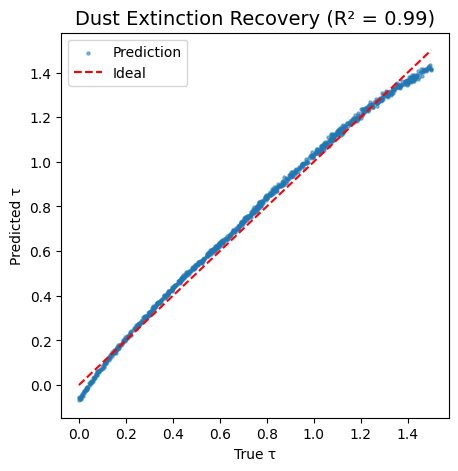

In [38]:
# Evaulation: prediction vs truth

model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        pred = model(x).cpu().numpy()
        y_pred.extend(pred)
        y_true.extend(y.numpy())


y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Computing R^2 score to evaluate the success of the prediction
r2 = r2_score(y_true, y_pred)

plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, s=5, alpha=0.5, label="Prediction")
plt.plot([0,1.5], [0,1.5], "r--", label="Ideal")
plt.xlabel("True τ")
plt.ylabel("Predicted τ")
plt.title(f"Dust Extinction Recovery (R² = {r2:.2f})", fontsize=14)
plt.legend()
plt.show()